In [1]:
import time 
import keras
import numpy as np 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from random import randint

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.datasets import make_classification

# Set random seed
np.random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# print('x_train.shape = {},  y_train.shape = {}'.format(x_train.shape, y_train.shape))
# print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

x_train_plt = x_train
y_train_labels=y_train

im_size = 784 # 28 x 28
# building the input vector from the 28x28 pixels
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalizing the data to help with the training
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices with one-hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


#SETTING ASIDE CALIBRATION DATA, TRAIN AND TEST
#a = np.random.shuffle(dataset)
x_cali = x_test[9250:10000]
y_cali = y_test[9250:10000]
x_test = x_test[0:9250]
y_test = y_test[0:9250]

print('x_train.shape = {},  y_train.shape = {}'.format(x_train.shape, y_train.shape))
print('x_cali.shape = {},  y_cali.shape = {}'.format(x_cali.shape, y_cali.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))


x_train.shape = (60000, 28, 28, 1),  y_train.shape = (60000, 10)
x_cali.shape = (750, 28, 28, 1),  y_cali.shape = (750, 10)
x_test.shape = (9250, 28, 28, 1),  y_test.shape = (9250, 10)


In [3]:
from keras.layers import Activation, Flatten
from keras.layers import Convolution2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras import optimizers

CUSTOM_OUTPUT_CATEGORIES = 10
IMAGE_RESCALE_SIZE = 28


BATCH_SIZE = 128

def DeepNet():
    # uses theano ordering. Note that we leave the image size as None to allow multiple image sizes
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(8, 8), strides = (2,2), padding = 'same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(128, kernel_size=(6, 6),  strides = (2,2), padding = 'valid', activation='relu'))
    model.add(Conv2D(128, kernel_size=(5, 5),  strides = (1,1), padding = 'valid',  activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer= adam,
                  metrics=['accuracy'])
    CUSTOM_TENSORBOARD.set_model(model)
    return model
  

In [4]:
# model = DeepNet()
# model_history = model.fit(x_train, y_train, epochs=10, batch_size=128)
# model.save('/BS/vedika2/nobackup/deepKNN_model.h5')  # creates a HDF5 file 

#for_future_reference- just load this
from keras.models import load_model
keras.backend.set_learning_phase(False)
# returns a compiled model
model = load_model('deepKNN_model.h5')

In [5]:
import random
np.random.seed(1234 )
model.evaluate(x_test,y_test, verbose=1)


9250/9250 [==============================] - 1s 92us/step


[0.0425313720213425, 0.9895135135135135]

In [6]:
from keras import backend as K
def reshaped_layer(model, x):
    #function to get the layer wise output representation of the model for data x
    layer_output = []
    for i in range(3):
        layer = model.layers[i]
        print(layer)
        l_op = K.function([model.layers[0].input],
                                      [layer.output])([x])[0]
        layer_output.append(l_op)
    layer_output.append(K.function([model.layers[0].input],
                                      [model.layers[4].output])([x])[0])
    print(model.layers[4])
    reshaped_output_layer = []
    for output in layer_output[0:3]:
        reshaped_output_layer.append(output.reshape(output.shape[0], output.shape[1]*output.shape[2]*output.shape[3]))
        
    for layer in layer_output[3:]:
        reshaped_output_layer.append(layer)
    
    for layer in reshaped_output_layer:
        assert layer.dtype == np.float32
        #print('Normalizing the dataset')
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)
        #print('Done')        
    return(reshaped_output_layer)

In [7]:
from __future__ import print_function
import numpy as np
import falconn
import timeit
import math


def keys(reshaped_output_layer,reshaped_output_layer_test, k_max, y_train):
    query_onject_list = []
    #keys2 = []
    closest_labels_2 = []
    for i in range(4):
        # we build only 50 tables, increasing this quantity will improve the query time
        # at a cost of slower preprocessing and larger memory footprint, feel free to
        # play with this number
        number_of_tables = 50
        dataset = reshaped_output_layer[i]
        center = np.mean(dataset, axis=0)
        dataset -= center
        params_cp = falconn.LSHConstructionParameters()
        params_cp.dimension = len(dataset[0])
        params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
        params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
        #params_cp.distance_function = falconn.DistanceFunction.NegativeInnerProduct
        params_cp.l = number_of_tables
        # we set one rotation, since the data is dense enough,
        # for sparse data set it to 2
        params_cp.num_rotations = 2
        params_cp.seed = 1234
        # we want to use all the available threads to set up
        params_cp.num_setup_threads = 0
        params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
        # we build 18-bit hashes so that each table has
        # 2^18 bins; this is a good choise since 2^18 is of the same
        # order of magnitude as the number of data points
        falconn.compute_number_of_hash_functions(18, params_cp)
        # print('Done')
        print('Constructing the LSH table')
        t1 = timeit.default_timer()
        table = falconn.LSHIndex(params_cp)
        table.setup(dataset)
        t2 = timeit.default_timer()
        # print('Done')
        print('Construction time: {}'.format(t2 - t1))
        query_object = table.construct_query_object()
        queries = reshaped_output_layer_test[i]
        queries -= center
        #keys = []   #len(keys)=100 equal to x_test size
        closest_labels = []
        for (j, query) in enumerate(queries):
            #print(i)
            a = query_object.find_k_nearest_neighbors(query, k_max)
            y_label = y_train[a]
            y_label_2 = []
            for i in range(y_label.shape[0]):
                y_label_2.append(argmax(y_label[i]))
            #keys.append(a)
            closest_labels.append(y_label_2)
        closest_labels_2.append(closest_labels)
        #keys2.append(keys)
    return(closest_labels_2)

In [8]:
def changing_transpose(y_test,close_l_p):
    a = []
    for z in range(len(y_test)): 
        b = []
        for i in range(4):
            #print(i)
            b.append(close_l_p[i][z])
        a.append(b)
    return(a)

In [9]:
def true_y_labels(y_train):
    y = []
    for i in range(len(y_train)):
        y.append(argmax(y_train[i]))
    return(y)

In [17]:
def getting_A(cali_closest_labels_found, cali_y_labels, k_max):
    alpha_x_y = []
    counter_all = 0
    for i in range(len(cali_y_labels)):
        a = cali_closest_labels_found[i]
        for j in range(4):
            while len(a[j]) < k_max: 
                #print('no neighbours found, appending class 99')
                a[j].append(99)  
                counter_all += 1            
        a = np.array(a)
        b = a.reshape(a.shape[0]*a.shape[1])
        label = cali_y_labels[i]
        c = np.full((a.shape[0]*a.shape[1]), label)
        d = (b != c).sum()          #non_conformity
        alpha_x_y.append(d)
    return alpha_x_y, counter_all

In [18]:
import numpy as np
from numpy import argmax
def metrics(closest_labels_found, A, k_max):  
    alpha_z_j = []
    alpha_z_j_2 = []
    p_j_z = []
    p_j_z_2 = []
    prediction = []
    credibility = []
    confidence = []
    counter_all = 0
    for z in range(len(closest_labels_found)):
        #print(z)
        a = closest_labels_found[z]
        for j in range(4):
            while len(a[j]) < k_max: 
                #print('no neighbours found, appending class 99')
                a[j].append(99)  
                counter_all += 1            
        a = np.array(closest_labels_found[z])       
        b = a.reshape(a.shape[0]*a.shape[1])
        #print(b)
        alpha_z_j = []
        p_j_z = []
        for label in range(10):     
            c = np.full((a.shape[0]*a.shape[1]), label)
            d = (b != c).sum()          #non_conformity
            alpha_z_j.append(d)         

            #number of values in A which are greater than alpha_z_j- whichh is d here
            e =  np.full((len(A)), d)    
            f = (A >= d).sum()
            g = f*(1/len(A))
            p_j_z.append(g)

        prediction.append(argmax(p_j_z))
        credibility.append(max(p_j_z))
        
        h = p_j_z
        del h[argmax(h)]   
        confidence.append(1 - max(h)) 


        alpha_z_j_2.append(alpha_z_j)   ###for other find this
        p_j_z_2.append(p_j_z)
 
    return(prediction, credibility, confidence, counter_all)

In [12]:
reshaped_output_layer = reshaped_layer(model, x_train)

In [13]:
#CALI_SET_the_complete_cycle_CALI_SET
t3 = timeit.default_timer()

reshaped_output_layer_cali = reshaped_layer(model, x_cali)
cali_close_l_p = keys(reshaped_output_layer, reshaped_output_layer_cali,75, y_train)
cali_closest_labels_found = changing_transpose(y_cali, cali_close_l_p)
cali_y_labels = true_y_labels(y_cali)

import pandas as pd 
pd.DataFrame(cali_closest_labels_found).to_csv("cali_output_file_closest_labels.csv")
pd.DataFrame(cali_y_labels).to_csv("cali_output_file_y_labels.csv")

t4 = timeit.default_timer()
# print('Done')
print('Construction time: {}'.format(t4 - t3))

Constructing the LSH table
Construction time: 249.88089350610971
Constructing the LSH table
Construction time: 56.43364958278835
Constructing the LSH table
Construction time: 3.0516576189547777
Constructing the LSH table
Construction time: 1.320563504472375
Construction time: 322.99449051730335


In [19]:
#getting_A for cali set
A, counter_cali = getting_A(cali_closest_labels_found, cali_y_labels, 75)

In [15]:
t5 = timeit.default_timer()

#the_complete_cycle_TEST SET
reshaped_output_layer_test = reshaped_layer(model, x_test)
close_l_p = keys(reshaped_output_layer, reshaped_output_layer_test, 75, y_train)
closest_labels_found = changing_transpose(y_test, close_l_p)
y_labels = true_y_labels(y_test)

import pandas as pd 
pd.DataFrame(closest_labels_found).to_csv("test_output_file_closest_labels.csv")
pd.DataFrame(y_labels).to_csv("test_output_file_y_labels.csv")

t6 = timeit.default_timer()
# print('Done')
print('Construction time: {}'.format(t6 - t5))

Constructing the LSH table
Construction time: 248.76021280139685
Constructing the LSH table
Construction time: 57.71041730232537
Constructing the LSH table
Construction time: 3.2220265809446573
Constructing the LSH table
Construction time: 1.4059606567025185
Construction time: 409.71101190522313


In [20]:
v,k,c, counter_test = metrics(closest_labels_found, A, 75)


In [21]:
p_acc =  np.mean(np.equal(v, y_labels))

In [22]:
p_acc

0.9889729729729729

In [ ]:
###Breaking the model by varying A, as prediction depends on comparing the closest labels 
# A- non confirmal scores wrt true labels
# so the way it works is, for every label in 1 to 10- for a z input- i get a non coformal score for the z's
# closest labels predicted
# A = [ 1 0 5 3]
# cl_l_pred = [[7,7,7], [7,7,7], [7,7,7], [7,7,7]]
#           0   1  2  3  4  5  6  7  8  9
#alpha_z_j= 12 12 12 12 12 12 12 0 12  12
# pred_z_j =0  0  0  0  0  0  0  4  0  0
# pred_z_j = for every j, we compare the number of lbels in A which were lesser than each apha_z_j
# and then argmax of pre_z_j guves the label being predicted which is 7

# so here we see- if I enforce the A to contain all 12- the model will break-  basocally the highest 
# value in alpha_z_j 


In [95]:
def breaking_model_varying_A(A, value,closest_labels_found,k_max, y_labels):
    A_adv = [value] * len(A)
    v_A_1,k_A_1,c_A_1, counter_test_A_1 = metrics(closest_labels_found, A_adv, k_max)
    p_acc_A_1 =  np.mean(np.equal(v_A_1, y_labels))
    print(value)
    print(p_acc_A_1)
    return(p_acc_A_1, v_A_1, k_A_1,c_A_1)

In [96]:
p_1 = breaking_model_varying_A(A, np.max(A), closest_labels_found, 75, y_labels)

292
0.7504864864864865


In [97]:
p_2, v_2, k_2, c_2 = breaking_model_varying_A(A, np.min(A), closest_labels_found, 75, y_labels)  ###forces all 0 into A, 
# value is going to be less than any alpha_z_j

0
0.1801081081081081


In [98]:
p_3,v_3, c_3, k_3 = breaking_model_varying_A(A, np.mean(A), closest_labels_found, 75, y_labels)

17.298666666666666
0.5848648648648649


In [23]:
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np
import keras
from keras import backend
from keras.models import load_model
import tensorflow as tf
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import SaliencyMapMethod
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.attacks import SpatialTransformationMethod

In [24]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
# Retrieve the tensorflow session
sess =  backend.get_session()
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.25,
               'clip_min': 0.0 ,
               'clip_max': 1.0 }
adv_x = fgsm.generate_np(x_test, **fgsm_params)
adv_pred = np.argmax(model.predict(adv_x), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, y_test[:,0]))
print("The adversarial accuracy for FGSM is: {}".format(adv_acc))

[INFO 2019-02-02 15:56:28,936 cleverhans] Constructing new graph for attack FastGradientMethod


The adversarial accuracy for FGSM is: 0.011027027027027026


In [111]:
import matplotlib.pyplot as plt
def plot(images,advs, name):
  n=images.shape[0]
  fig = plt.figure()
  for i in range(n):
    im=(np.reshape(images[i], (28, 28)) * 255).astype(np.uint8)
    adv=(np.reshape(advs[i], (28, 28)) * 255).astype(np.uint8)
    plt.subplot(2,n,i+1)
    plt.imshow(im, cmap='gray')
    plt.axis('off') 
    
    plt.subplot(2,n,(i+1+n))
    plt.imshow(adv, cmap='gray')
    plt.axis('off') 
    
    
  plt.show()
  fig.savefig(name + ".png", bbox_inches='tight')

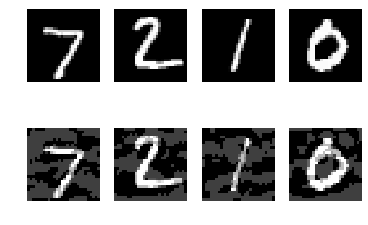

In [115]:
plot(x_test[:4],adv_x[:4], 'fgsm')

In [25]:
t9 = timeit.default_timer()

#the_complete_cycle_TEST SET
reshaped_output_layer_adv = reshaped_layer(model, adv_x)
adv_close_l_p = keys(reshaped_output_layer, reshaped_output_layer_adv, 75, y_train)
adv_closest_labels_found = changing_transpose(y_test, adv_close_l_p)
y_labels = true_y_labels(y_test)

import pandas as pd 
pd.DataFrame(closest_labels_found).to_csv("adv_output_file_closest_labels.csv")
pd.DataFrame(y_labels).to_csv("adv_output_file_y_labels.csv")

t10 = timeit.default_timer()
# print('Done')
print('Construction time: {}'.format(t10 - t9))

Constructing the LSH table
Construction time: 252.7428024765104
Constructing the LSH table
Construction time: 56.17226270958781
Constructing the LSH table
Construction time: 3.0669281017035246
Constructing the LSH table
Construction time: 1.318841913715005
Construction time: 390.0276181064546


In [26]:
v_adv,k_adv,c_adv, counter_adv = metrics(adv_closest_labels_found, A, 75)

In [27]:
p_acc_adv =  np.mean(np.equal(v_adv, y_labels))

In [28]:
counter_adv/(75*4*9250)

0.11003711711711711

In [29]:
p_acc_adv

0.3938378378378378

In [30]:
### Spatial Tranformation Method: Black Box attack
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
# Retrieve the tensorflow session
sess =  backend.get_session()
wrap = KerasModelWrapper(model)
stm = SpatialTransformationMethod(wrap, sess=sess)
adv_x_stm = stm.generate_np(x_test)
adv_pred_stm = np.argmax(model.predict(adv_x_stm), axis = 1)
adv_acc_stm =  np.mean(np.equal(adv_pred_stm, y_test[:,0]))


[INFO 2019-02-02 16:03:08,302 cleverhans] Constructing new graph for attack SpatialTransformationMethod


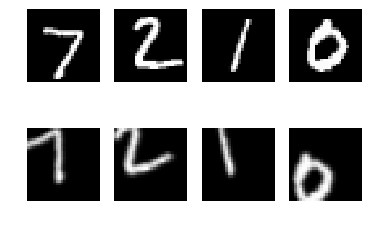

In [116]:
plot(x_test[:4],adv_x_stm[:4], 'stm')

In [31]:
print("The adversarial accuracy for STM is: {}".format(adv_acc_stm))

The adversarial accuracy for STM is: 0.01027027027027027


In [33]:
t11 = timeit.default_timer()

#the_complete_cycle_TEST SET
reshaped_output_layer_adv_stm = reshaped_layer(model, adv_x_stm)
adv_close_l_p_stm = keys(reshaped_output_layer, reshaped_output_layer_adv_stm, 75, y_train)
adv_closest_labels_found_stm = changing_transpose(y_test, adv_close_l_p_stm)
y_labels = true_y_labels(y_test)

import pandas as pd 
pd.DataFrame(closest_labels_found).to_csv("adv_stm_output_file_closest_labels.csv")
pd.DataFrame(y_labels).to_csv("adv_stm_output_file_y_labels.csv")

t12 = timeit.default_timer()
# print('Done')
print('Construction time: {}'.format(t12 - t11))

Constructing the LSH table
Construction time: 248.90838314034045
Constructing the LSH table
Construction time: 56.389617605134845
Constructing the LSH table
Construction time: 3.033067472279072
Constructing the LSH table
Construction time: 1.3126030769199133
Construction time: 380.10503472201526


In [34]:
v_adv_stm,k_adv_stm,c_adv_stm, counter_adv_stm = metrics(adv_closest_labels_found_stm, A, 75)

In [35]:
p_acc_adv_stm =  np.mean(np.equal(v_adv_stm, y_labels))

In [36]:
p_acc_adv_stm

0.0007567567567567568

In [118]:
bim = BasicIterativeMethod(wrap, sess=sess)
bim_params = {'eps_iter': 0.01,
              'nb_iter': 100,
              'clip_min': 0.,
              'clip_max': 1.}
adv_bim = bim.generate_np(x_test, **bim_params)
adv_pred_bim = np.argmax(model.predict(adv_bim), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred_bim, np.argmax(y_test,axis=1)))
# adv_acc_knn =  np.mean(np.equal(adv_pred_bim, predTest))
print("The adversarial accuracy for BIM on DNN is: {}".format(adv_acc))
# print("The adversarial accuracy for BIM on DkNN is: {}".format(adv_acc_knn))

[INFO 2019-02-03 17:08:34,504 cleverhans] Constructing new graph for attack BasicIterativeMethod


The adversarial accuracy for BIM on DNN is: 0.008108108108108109


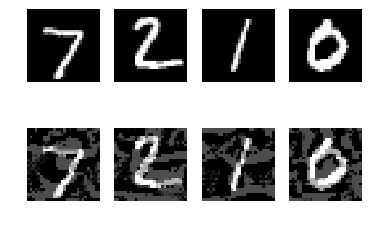

In [130]:
plot(x_test[:4],adv_bim[:4], 'bim')

In [125]:
# parse_params(layer=None, eps=0.3, eps_iter=0.05, nb_iter=10, ord=inf, clip_min=None,
# clip_max=None, **kwargs)

bim = BasicIterativeMethod(wrap, sess=sess)
bim_params_2 = {'eps': 0.25,
              'eps_iter': 0.01,
              'nb_iter': 100 }
adv_bim_2 = bim.generate_np(x_test, **bim_params_2)


[INFO 2019-02-03 17:50:14,711 cleverhans] Constructing new graph for attack BasicIterativeMethod


The adversarial accuracy for BIM on DNN is: 0.008108108108108109


In [127]:
adv_pred_bim_2 = np.argmax(model.predict(adv_bim_2), axis = 1)
adv_acc_2 =  np.mean(np.equal(adv_pred_bim_2, np.argmax(y_test,axis=1)))
# adv_acc_knn =  np.mean(np.equal(adv_pred_bim, predTest))
print("The adversarial accuracy for BIM_2 on DNN is: {}".format(adv_acc_2))
# print("The adversarial accuracy for BIM2 on DkNN is: {}".format(adv_acc_knn))

The adversarial accuracy for BIM_2 on DNN is: 0.010486486486486486


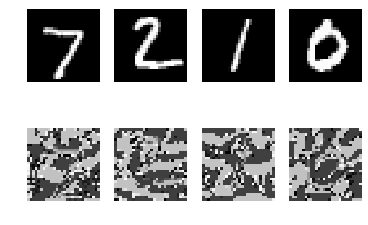

In [131]:
plot(x_test[:4],adv_bim_2[:4], 'bim_2')

In [120]:
t21 = timeit.default_timer()

#the_complete_cycle_TEST SET
reshaped_output_layer_adv_bim = reshaped_layer(model, adv_bim)
adv_close_l_p_bim = keys(reshaped_output_layer, reshaped_output_layer_adv_bim, 75, y_train)
adv_closest_labels_found_bim = changing_transpose(y_test, adv_close_l_p_bim)
y_labels = true_y_labels(y_test)
t22 = timeit.default_timer()
# print('Done')
print('Construction time: {}'.format(t22 - t21))

Constructing the LSH table
Construction time: 275.82230691611767
Constructing the LSH table
Construction time: 59.83594779111445
Constructing the LSH table
Construction time: 3.1716802194714546
Constructing the LSH table
Construction time: 1.3381790034472942
Construction time: 419.7375308033079


In [135]:
v_adv_bim,k_adv_bim,c_adv_bim, counter_adv_bim = metrics(adv_closest_labels_found_bim, A, 75)
p_acc_adv_bim =  np.mean(np.equal(v_adv_bim, y_labels))
p_acc_adv_bim

0.024972972972972973

In [136]:
def short(model, adv_bim):
    t21 = timeit.default_timer()
    #the_complete_cycle_TEST SET
    reshaped_output_layer_adv_bim = reshaped_layer(model, adv_bim)
    adv_close_l_p_bim = keys(reshaped_output_layer, reshaped_output_layer_adv_bim, 75, y_train)
    adv_closest_labels_found_bim = changing_transpose(y_test, adv_close_l_p_bim)
    y_labels = true_y_labels(y_test)
    t22 = timeit.default_timer()
    # print('Done')
    print('Construction time: {}'.format(t22 - t21))
    v_adv_bim,k_adv_bim,c_adv_bim, counter_adv_bim = metrics(adv_closest_labels_found_bim, A, 75)
    p_acc_adv_bim =  np.mean(np.equal(v_adv_bim, y_labels))
    return(p_acc_adv_bim)
    

In [137]:
short(model,adv_bim_2 )

Constructing the LSH table
Construction time: 277.9549850784242
Constructing the LSH table
Construction time: 60.558503780514
Constructing the LSH table
Construction time: 3.398089498281479
Constructing the LSH table
Construction time: 1.3560465723276138
Construction time: 425.93725552782416


0.01935135135135135

In [42]:
tf.set_random_seed(1234)
# Retrieve the tensorflow session
sess =  backend.get_session()
wrap = KerasModelWrapper(model)
from cleverhans.utils import other_classes
def saliency_map_method(sess, model, X, Y, theta, gamma, clip_min=None, clip_max=None):
    
    nb_classes = Y.shape[1]
    X_adv = np.zeros_like(X)
    # Instantiate a SaliencyMapMethod attack object
    jsma = SaliencyMapMethod(model, back='tf', sess=sess)
    jsma_params = {'theta': theta, 'gamma': gamma,
                   'clip_min': clip_min, 'clip_max': clip_max,
                   'y_target': None}
    for i in range(X.shape[0]):
        # Get the sample
        sample = X[i:(i+1)]
        # First, record the current class of the sample
        current_class = int(np.argmax(Y[i]))
        # Randomly choose a target class
        target_class = np.random.choice(other_classes(nb_classes,
                                                      current_class))
        # This call runs the Jacobian-based saliency map approach
        one_hot_target = np.zeros((1, nb_classes), dtype=np.float32)
        one_hot_target[0, target_class] = 1
        jsma_params['y_target'] = one_hot_target
        X_adv[i] = jsma.generate_np(sample, **jsma_params)

    return X_adv

adv_jsma = saliency_map_method(sess, wrap, x_test, y_test, theta=1, gamma=0.1, clip_min=0., clip_max=1.)

[INFO 2019-02-02 16:33:23,502 cleverhans] Constructing new graph for attack SaliencyMapMethod


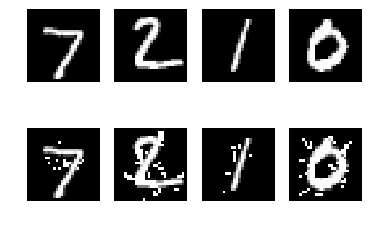

In [122]:
plot(x_test[:4],adv_jsma[:4], 'jsma')

In [55]:
adv_pred_jsma = np.argmax(model.predict(adv_jsma), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred_jsma, np.argmax(y_test,axis=1)))
# adv_acc_knn =  np.mean(np.equal(adv_pred_jsma, predTest))
print("The adversarial accuracy for JSMA on DNN is: {}".format(adv_acc))
# print("The adversarial accuracy for STM on DkNN is: {}".format(adv_acc_knn))

The adversarial accuracy for JSMA on DNN is: 0.08421621621621622


In [138]:
t13 = timeit.default_timer()

#the_complete_cycle_TEST SET
reshaped_output_layer_adv_jsma = reshaped_layer(model, adv_jsma)
adv_close_l_p_jsma = keys(reshaped_output_layer, reshaped_output_layer_adv_jsma, 75, y_train)
adv_closest_labels_found_jsma = changing_transpose(y_test, adv_close_l_p_jsma)
t14 = timeit.default_timer()
# print('Done')
print('Construction time: {}'.format(t14 - t13))

Constructing the LSH table
Construction time: 292.4895556997508
Constructing the LSH table
Construction time: 60.992687018588185
Constructing the LSH table
Construction time: 3.278316618874669
Constructing the LSH table
Construction time: 1.340169696137309
Construction time: 444.5197242721915


In [54]:
pd.DataFrame(adv_closest_labels_found_jsma).to_csv("adv_jsma_output_file_closest_labels.csv")

v_adv_jsma,k_adv_jsma,c_adv_jsma, counter_adv_jsma = metrics(adv_closest_labels_found_jsma, A, 75)
p_acc_adv_jsma =  np.mean(np.equal(v_adv_jsma, y_labels))
p_acc_adv_jsma

0.5581621621621622

In [39]:
import pickle

# # obj0, obj1, obj2 are created here...

# # Saving the objects:
# with open('objs.pkl', 'w') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([obj0, obj1, obj2], f)

# # Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)

import pickle
# Saving the objects:
with open('file.pkl', 'wb') as f:  
    # Python 3: open(..., 'wb')
    pickle.dump([cali_closest_labels_found,closest_labels_found, adv_closest_labels_found, adv_closest_labels_found_stm], f)
 

In [41]:
with open('A.pkl', 'wb') as f:  
    # Python 3: open(..., 'wb')
    pickle.dump([A], f)